In [1]:
import numpy as np
import matplotlib.pyplot as plt

ph = np.load('Photon.npy')
ele = np.load('Electron.npy')
pi0 = np.load('Pizero.npy')
pipm = np.load('Piplusminus.npy')

In [2]:
data = np.vstack((ph[:100000,:],ele[:100000,:],pi0[:100000,:],pipm[:100000,:]))
datatest = np.vstack((ph[100000:125000,:],ele[100000:125000,:],pi0[100000:125000,:],pipm[100000:125000,:]))
datatest.shape

(100000, 323)

In [3]:
truez = data[:,2]
psb = data[:,20:83]
emb1 = data[:,83:134]
emb2 = data[:,134:197]
emb3 = data[:,197:260]                   
hab1 = data[:,260:]

# sum of all cells
cells_sum = np.sum(data[:,20:],axis=1).reshape(-1,1)

# sum of layers in phi
psb_sum = np.sum(psb.reshape(-1,7,9),axis=1)
emb1_sum = np.sum(emb1.reshape(-1,3,17),axis=1)
emb2_sum = np.sum(emb2.reshape(-1,7,9),axis=1)
emb3_sum = np.sum(emb3.reshape(-1,7,9),axis=1)
hab1_sum = np.sum(hab1.reshape(-1,7,9),axis=1)

# normalised sums
psb_nsum = psb_sum / cells_sum
emb1_nsum = emb1_sum / cells_sum
emb2_nsum = emb2_sum / cells_sum
emb3_nsum = emb3_sum / cells_sum
hab1_nsum = hab1_sum / cells_sum

# center eta of layers
psb_eta = data[:,6]
emb1_eta = data[:,8]
emb2_eta = data[:,10]
emb3_eta = data[:,12]
hab1_eta = data[:,14]
differ1 = psb_eta - emb1_eta
differ2 = emb1_eta - emb2_eta
differ3 = emb2_eta - emb3_eta
differ4 = emb3_eta - hab1_eta

In [4]:
train = np.column_stack((psb_nsum[:,3],psb_nsum[:,4],psb_nsum[:,5],emb1_nsum[:,7],emb1_nsum[:,8],emb1_nsum[:,9],
                          emb2_nsum[:,3],emb2_nsum[:,4],emb2_nsum[:,5],emb1_eta,differ1,differ2))

train_target = truez

In [5]:
truezt = datatest[:,2]
psbt = datatest[:,20:83]
emb1t = datatest[:,83:134]
emb2t = datatest[:,134:197]
emb3t = datatest[:,197:260]                   
hab1t = datatest[:,260:]

# sum of all cells
cells_sumt = np.sum(datatest[:,20:],axis=1).reshape(-1,1)

# sum of layers in phi
psb_sumt = np.sum(psbt.reshape(-1,7,9),axis=1)
emb1_sumt = np.sum(emb1t.reshape(-1,3,17),axis=1)
emb2_sumt = np.sum(emb2t.reshape(-1,7,9),axis=1)
emb3_sumt = np.sum(emb3t.reshape(-1,7,9),axis=1)
hab1_sumt = np.sum(hab1t.reshape(-1,7,9),axis=1)

# normalised sums
psb_nsumt = psb_sumt / cells_sumt
emb1_nsumt = emb1_sumt / cells_sumt
emb2_nsumt = emb2_sumt / cells_sumt
emb3_nsumt = emb3_sumt / cells_sumt
hab1_nsumt = hab1_sumt / cells_sumt

# center eta of layers
psb_etat = datatest[:,6]
emb1_etat = datatest[:,8]
emb2_etat = datatest[:,10]
emb3_etat = datatest[:,12]
hab1_etat = datatest[:,14]
differ1t = psb_etat - emb1_etat
differ2t = emb1_etat - emb2_etat
differ3t = emb2_etat - emb3_etat
differ4t = emb3_etat - hab1_etat

In [6]:
test = np.column_stack((psb_nsumt[:,3],psb_nsumt[:,4],psb_nsumt[:,5],emb1_nsumt[:,7],emb1_nsumt[:,8],emb1_nsumt[:,9],
                          emb2_nsumt[:,3],emb2_nsumt[:,4],emb2_nsumt[:,5],emb1_etat,differ1t,differ2t))

test_target = truezt

In [7]:
import xgboost as xgb

# create the xgboost model
model = xgb.XGBRegressor(
    learning_rate=0.2,    # Controls the step size shrinkage
    n_estimators=600,      # Number of boosting rounds or trees
    max_depth=6,     # Maximum depth of a tree
    objective='reg:squarederror')

model.fit(train, train_target)
ypred = model.predict(test)

# calculate RMS
def RMS(actual,predict):
    residual = actual - predict
    return np.sqrt(np.mean(residual**2))

print(RMS(test_target,ypred))

66.36238859309402


In [8]:
def performance(n,d):
    'input number of boosting rounds and maximum tree depth'
    model = xgb.XGBRegressor(learning_rate=0.2, n_estimators = n, max_depth = d, objective='reg:squarederror')
    # train model
    model.fit(train, train_target)
    ypred = model.predict(test)
    # calculate MSE
    residual = test_target-ypred
    MSE = np.mean(residual**2)
    # count number of nodes
    dump_list = model.get_booster().get_dump()
    nodes = 0
    for tree_structure in dump_list:
        nodes += len(tree_structure.split('\n')) - 1

    return MSE, nodes

Text(0.5, 1.0, 'Correlation of performance of the BDT model to its size')

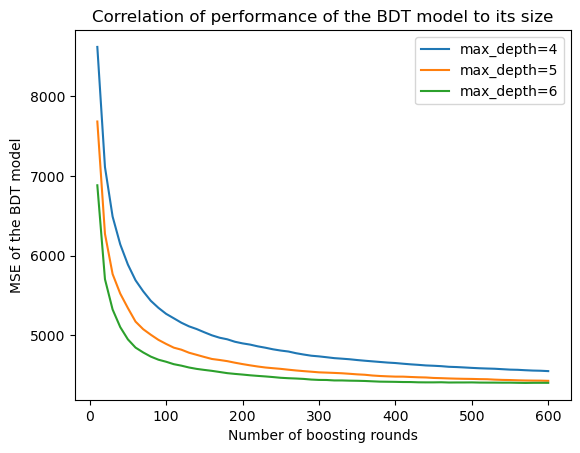

In [9]:
N = np.arange(10, 601, 10)
MSE_4 = np.zeros(len(N))
MSE_5 = np.zeros(len(N))
MSE_6 = np.zeros(len(N))
N4 = np.zeros(len(N))
N5 = np.zeros(len(N))
N6 = np.zeros(len(N))

for i in range(len(N)):
    MSE_4[i] = performance(N[i],4)[0]
    MSE_5[i] = performance(N[i],5)[0]
    MSE_6[i] = performance(N[i],6)[0]
    N4[i] = performance(N[i],4)[1]
    N5[i] = performance(N[i],5)[1]
    N6[i] = performance(N[i],6)[1]
    
plt.figure()
plt.plot(N,MSE_4,label='max_depth=4')
plt.plot(N,MSE_5,label='max_depth=5')
plt.plot(N,MSE_6,label='max_depth=6')
plt.legend()
plt.xlabel("Number of boosting rounds")
plt.ylabel("MSE of the BDT model")
plt.title("Correlation of performance of the BDT model to its size")

Text(0.5, 1.0, 'Correlation of performance of the BDT model to the number of nodes')

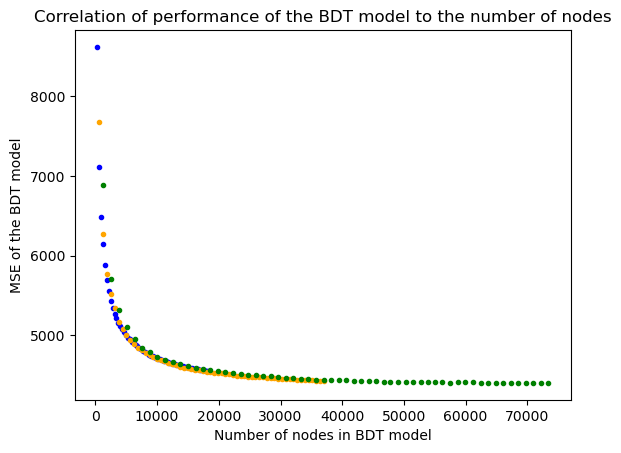

In [11]:
plt.figure()
plt.plot(N4,MSE_4,'.',color="blue")
plt.plot(N5,MSE_5,'.',color="orange")
plt.plot(N6,MSE_6,'.',color="green")
plt.xlabel("Number of nodes in BDT model")
plt.ylabel("MSE of the BDT model")
plt.title("Correlation of performance of the BDT model to the number of nodes")

In [50]:
import pandas as pd

x = np.hstack((N4,N5,N6))
y = np.hstack((MSE_4,MSE_5,MSE_6))

df = pd.DataFrame({'Number of Nodes': x, 'MSE of Model (mm)': y})
sorted_df = df.sort_values(by='Number of Nodes', ascending=True) 

filtered_df = sorted_df[(sorted_df['Number of Nodes'] < 10000)&(sorted_df['MSE of Model (mm)'] < 4761)]

filtered_df

,Number of Nodes,MSE of Model (mm)
27,8648.0,4759.173676
73,8772.0,4755.387050
28,8958.0,4744.322199
29,9264.0,4736.015529
74,9396.0,4728.532515
30,9574.0,4725.277870
31,9870.0,4713.954168


In [21]:
import xgboost
from xgboost import Booster

def count_nodes(model):
    if isinstance(model, Booster):
        trees = model.trees_to_dataframe()
    else:
        trees = model.get_booster().trees_to_dataframe()

    return sum(trees["Split"].notna())

count_nodes(model)

36395